# Install TODS

In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install -e git+https://github.com/datamllab/tods.git@dev#egg=tods 

Obtaining tods from git+https://github.com/datamllab/tods.git@dev#egg=tods
  Updating ./src/tods clone (to revision dev)
  Running command git fetch -q --tags
  Running command git reset --hard -q feb0c9c48b750c1dc4b9d60b5884b93d7824e77b
  Preparing metadata (setup.py) ... done
  Attempting uninstall: tods
    Found existing installation: tods 0.0.2
    Uninstalling tods-0.0.2:
      Successfully uninstalled tods-0.0.2
  DEPRECATION: Legacy editable install of tods from git+https://github.com/datamllab/tods.git@dev#egg=tods (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for tods


In [1]:
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
import sklearn as sk
import time
from sklearn.datasets import fetch_openml

from tods.sk_interface.detection_algorithm.OCSVM_skinterface import OCSVMSKI
from tods.sk_interface.detection_algorithm.KNN_skinterface import KNNSKI

2024-09-27 20:57:15.659913: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-27 20:57:15.659930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# df = pd.read_csv('./Data/multivariate/Occupancy/room-occupancy-0.test.csv')
df = pd.read_csv('./Data/multivariate/Exathlon/2_1_100000_60-20.test.csv')
df.drop(["timestamp"], axis = 1, inplace = True)
df.head()

,1_jvm_heap_max_value,1_jvm_pools_PS-Eden-Space_max_value,1_jvm_pools_PS-Survivor-Space_committed_value,2_jvm_heap_committed_value,driver_BlockManager_memory_memUsed_MB_value,driver_BlockManager_memory_remainingMem_MB_value,driver_DAGScheduler_stage_waitingStages_value,node5_NET_ib0-write-KB/s,node6_CPU031_User%,node6_NETPACKET_em1-write/s,node6_NET_ib0-write-KB/s,node7_NET_ib0-read-KB/s,is_anomaly
0,-1.000000e+00,-1.000000e+00,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,23.6,1.0,0.0,131921.3,3.2,0
1,-1.000000e+00,-1.000000e+00,-1.0,-1.000000e+00,-1.0,-1.0,-1.0,84.3,1.0,20.9,150.7,2.1,0
2,-1.000000e+00,-1.000000e+00,-1.0,1.526202e+09,0.0,81200.0,1.0,2.2,3.0,48.9,10.2,0.7,0
3,7.635730e+09,2.684879e+09,89128960.0,1.526202e+09,0.0,81200.0,1.0,9.6,3.0,47614.3,5.7,0.8,0
4,7.635730e+09,2.684879e+09,89128960.0,1.526202e+09,0.0,81200.0,0.0,0.9,10.1,58671.4,193.9,3.3,0


In [3]:
print(df.columns[:-1]) #feature_names

Index(['1_jvm_heap_max_value', '1_jvm_pools_PS-Eden-Space_max_value',
       '1_jvm_pools_PS-Survivor-Space_committed_value',
       '2_jvm_heap_committed_value',
       'driver_BlockManager_memory_memUsed_MB_value',
       'driver_BlockManager_memory_remainingMem_MB_value',
       'driver_DAGScheduler_stage_waitingStages_value',
       'node5_NET_ib0-write-KB/s', 'node6_CPU031_User%',
       'node6_NETPACKET_em1-write/s', 'node6_NET_ib0-write-KB/s',
       'node7_NET_ib0-read-KB/s'],
      dtype='object')


In [4]:
def remove_files_from_directory(directory):
    # Get all files in the directory
    files = glob.glob(os.path.join(directory, "*"))
    
    # Loop through the files and remove each one
    for file in files:
        if os.path.isfile(file):
            os.remove(file)
    
    print(f"All files in {directory} have been removed.")

In [5]:
feature_folder = 'features'
remove_files_from_directory(feature_folder)
os.makedirs(feature_folder, exist_ok=True)

All files in features have been removed.


In [6]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Further split X_train and y_train into 7 subsets
num_sets = 7
X_train_sets = np.array_split(X_train, num_sets)
y_train_sets = np.array_split(y_train, num_sets)

# Create y_label_sets to hold the set number (0 to 6)
y_label_sets = [np.full(y_set.shape, i) for i, y_set in enumerate(y_train_sets)]
set_numbers = np.concatenate(y_label_sets)

# Displaying the shapes of the resulting subsets
for i in range(num_sets):
    print(f"Set {i + 1}:")
    print(f"X_train_set shape: {X_train_sets[i].shape}, y_train_set shape: {y_train_sets[i].shape}")
    print("=" * 40)

(37324, 12) (9331, 12) (37324,) (9331,)
Set 1:
X_train_set shape: (5332, 12), y_train_set shape: (5332,)
Set 2:
X_train_set shape: (5332, 12), y_train_set shape: (5332,)
Set 3:
X_train_set shape: (5332, 12), y_train_set shape: (5332,)
Set 4:
X_train_set shape: (5332, 12), y_train_set shape: (5332,)
Set 5:
X_train_set shape: (5332, 12), y_train_set shape: (5332,)
Set 6:
X_train_set shape: (5332, 12), y_train_set shape: (5332,)
Set 7:
X_train_set shape: (5332, 12), y_train_set shape: (5332,)


importances [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0
important_features ['1_jvm_heap_max_value', '1_jvm_pools_PS-Eden-Space_max_value', '1_jvm_pools_PS-Survivor-Space_committed_value', '2_jvm_heap_committed_value', 'driver_BlockManager_memory_memUsed_MB_value']
X_train_class [[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.52620237e+09
   0.00000000e+00]
 ...
 [ 7.63573043e+09  2.56324403e+09  1.37363456e+08  5.54382131e+09
   4.55000000e+02]
 [ 7.63573043e+09  2.56324403e+09  1.37363456e+08  5.54382131e+09
   4.70000000e+02]
 [ 7.63573043e+09  2.56324403e+09  1.37363456e+08  5.54382131e+09
   2.89000000e+02]]
Shape of X_train_class: (5332, 5)
y_train_class 0       0
1       0
2       0
3       0
4       0
       ..
5327    0
5328    0
5329    0
5330    0
5331    0
Name: is_anomaly, Length: 5332, dtype: int64
0 impo

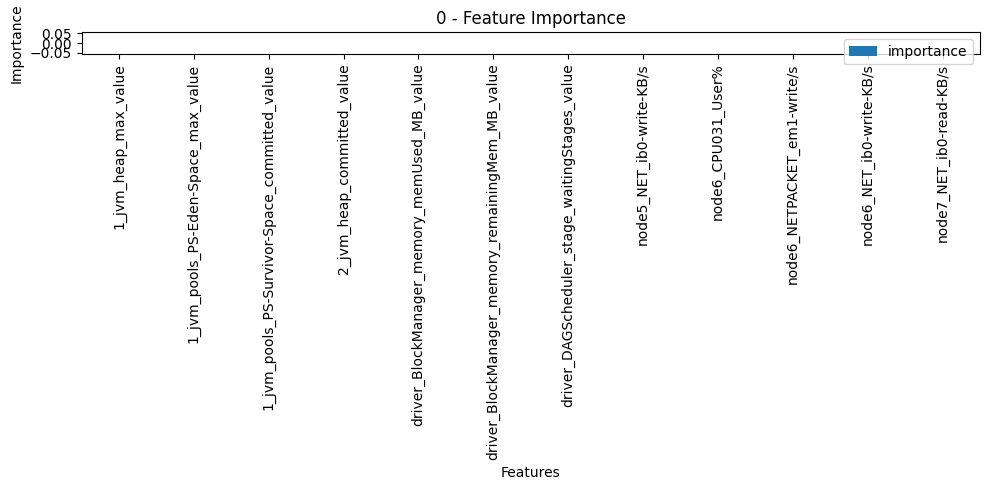

-----------------------------------------------------------------------------------------------




importances [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1
important_features ['1_jvm_heap_max_value', '1_jvm_pools_PS-Eden-Space_max_value', '1_jvm_pools_PS-Survivor-Space_committed_value', '2_jvm_heap_committed_value', 'driver_BlockManager_memory_memUsed_MB_value']
X_train_class [[7.63573043e+09 2.53807821e+09 1.62529280e+08 5.54382131e+09
  2.97000000e+02]
 [7.63573043e+09 2.53807821e+09 1.62529280e+08 5.54382131e+09
  3.12000000e+02]
 [7.63573043e+09 2.53807821e+09 1.62529280e+08 5.53648128e+09
  3.28000000e+02]
 ...
 [7.63573043e+09 2.45838643e+09 2.03948032e+08 5.46937242e+09
  3.19000000e+02]
 [7.63573043e+09 2.45838643e+09 2.03948032e+08 5.47880960e+09
  3.27000000e+02]
 [7.63573043e+09 2.45838643e+09 2.03948032e+08 5.47880960e+09
  3.42000000e+02]]
Shape of X_train_class: (5332, 5)
y_train_class 5332     0
5333     0
5334     0
5335     0
5336     0
        ..
10659    0
10660    0
106

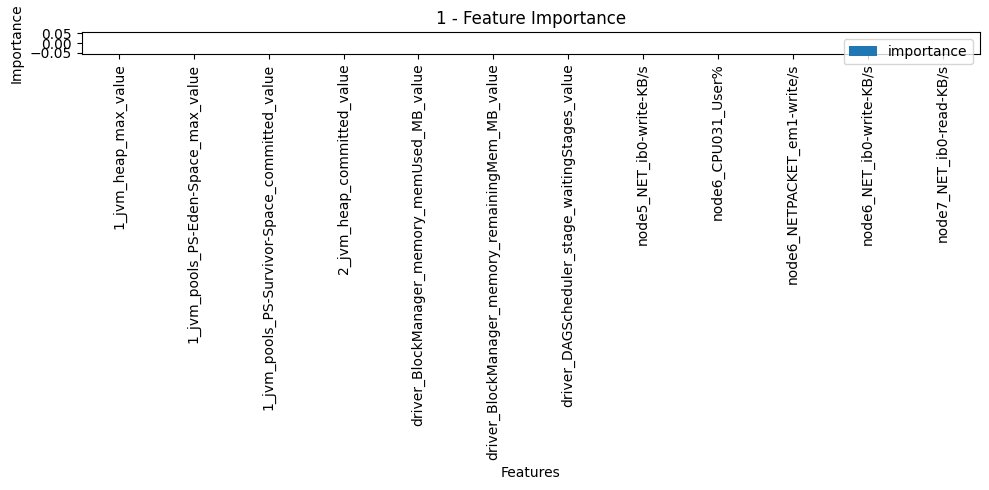

-----------------------------------------------------------------------------------------------




importances [5.64636371e-05 3.95631812e-02 1.05500195e-02 5.84797598e-03
 4.83274456e-01 4.60693545e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.85377679e-06 9.50460966e-06] 2
important_features ['driver_BlockManager_memory_memUsed_MB_value', 'driver_BlockManager_memory_remainingMem_MB_value', '1_jvm_pools_PS-Eden-Space_max_value', '1_jvm_pools_PS-Survivor-Space_committed_value', '2_jvm_heap_committed_value']
X_train_class [[3.57000000e+02 8.08420000e+04 2.45838643e+09 2.03948032e+08
  5.47880960e+09]
 [3.69000000e+02 8.08310000e+04 2.45838643e+09 2.03948032e+08
  5.47880960e+09]
 [3.84000000e+02 8.08160000e+04 2.45838643e+09 2.03948032e+08
  5.47880960e+09]
 ...
 [3.58000000e+02 8.08420000e+04 2.57058406e+09 1.41557760e+08
  5.16633395e+09]
 [3.77000000e+02 8.08220000e+04 2.57058406e+09 1.41557760e+08
  5.20513126e+09]
 [3.85000000e+02 8.08150000e+04 2.57215693e+09

In [ ]:
seconds = time.time()

ths = open("importance_list.csv", "w")
feature_importances = {}
SVMs = {}

for i, (X_set, y_set) in enumerate(zip(X_train_sets, y_train_sets)):
    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X_set, y_set)
    importances = forest.feature_importances_
    print('importances', importances, i)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    num_features = len(importances)
    num_display = min(num_features, 20)  # Only display up to the maximum available features
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:num_display],'importance':importances[0:num_display]})
    impor_bars = impor_bars.sort_values('importance',ascending=False)
    important_features = impor_bars['Features'].to_list()[:5]
    impor_bars = impor_bars.set_index('Features')
    print('important_features', important_features)
    feature_importances[i] = important_features
    
    svm = OCSVMSKI()
    X_train_class = np.array(X_set.iloc[:, X_set.columns.get_indexer(important_features)])
    print('X_train_class', X_train_class)
    if isinstance(X_train_class, np.ndarray):
        print("Shape of X_train_class:", X_train_class.shape)
    else:
        print("X_train_class is not a numpy array.")
    y_train_class = y_set
    print('y_train_class', y_train_class)
    if len(y_train_class) > 0:  # Ensure there are samples for this class
        svm.fit(X_train_class)
    else:
        print(f'no data for {i}')
    SVMs[i] = svm
    
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=str(i)+"=["
    for j in impor_bars.index:
        fea_ture=fea_ture+"\""+str(j)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(i,"importance list:")
    print(i,"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(str(i)+" - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig(os.path.join(feature_folder, str(i)+".pdf"),bbox_inches='tight', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances', feature_importances)
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()



In [ ]:
# TEST_COUNT = 100

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, set_numbers)

# Step 2: Predict classes for the test set
knn_predictions = knn.predict(np.array(X_test))
print('knn_predictions', knn_predictions)

In [9]:
# y_test = y_test[:TEST_COUNT]
# print("KNN Evaluation:")
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, knn_predictions))
# print(confusion_matrix(y_test, knn_predictions))
# print("\nClassification Report:")
# print(classification_report(y_test, knn_predictions))
# print("Accuracy:", accuracy_score(y_test, knn_predictions))

In [10]:
svm_predictions = []

for i in range(X_test.shape[0]):
    # test_instance = X_test.iloc[i]
    predicted_label = knn_predictions[i]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    test_instance_selected = X_test.iloc[i, X.columns.get_indexer(selected_features)].values.reshape(1, -1)
    # print('test_instance_selected', test_instance_selected)
    
    svm_prediction = svm_model.predict(np.array(test_instance_selected))
    # print(svm_prediction)
    svm_predictions.append(svm_prediction)

In [ ]:
# print("y_true:", y_test.values)
svm_predictions_flattened = np.array([pred[0, 0] for pred in svm_predictions])
# print("y_pred:", svm_predictions_flattened)

print("Confusion Matrix:")
print(confusion_matrix(y_test.values, svm_predictions_flattened))
print("\nClassification Report:")
print(classification_report(y_test.values, svm_predictions_flattened))
print("Accuracy:", accuracy_score(y_test.values, svm_predictions_flattened))

# Optionally, you can also compute the overall accuracy
# overall_accuracy = accuracy_score(y_test, np.concatenate((svm_predictions, knn_predictions[~anomaly_mask])))
# print("\nOverall Accuracy:", overall_accuracy)